# In this notebook, I'm going to apply what I've learned so far in the fast.ai deep learning 1 course. The hope is that, with practice, I'll get more comfortable with the ins and outs of the fastai library, and gain some insight as to how to use it for the Flint project. 

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [1]:
# Imports from kaggle kernel (example for this competition)
import shutil
import os
import sys
sys.path.append('../../fastai') # I think this line was to point to the fastai directory with all its modules

import pandas as pd
import numpy as np
from PIL import Image, ImageFilter
from scipy.ndimage import filters

In [2]:
# Imports at the start of every fastai notebook (The MEAT)
from fastai.imports import *

In [3]:
# More from fastai notebooks
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [5]:
torch.cuda.set_device(0)

In [6]:
torch.cuda.is_available() #This line checks for the prescence of a gpu (&CUDA)

True

In [7]:
torch.backends.cudnn.enabled

True

# Data Prep (I can skip some of these steps after initial prep)

In [5]:
# Checking out the training dataframe, reading in the json file
train_df = pd.read_json('../../../iceberg/data/processed/train.json')
train_df['inc_angle'] = pd.to_numeric(train_df['inc_angle'], errors='coerce')

In [6]:
train_df.shape

(1604, 5)

In [7]:
train_df.head()

,band_1,band_2,id,inc_angle,is_iceberg
0,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",dfd5f913,43.9239,0
1,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",e25388fd,38.1562,0
2,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",58b2aaa0,45.2859,1
3,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",4cfc3a18,43.8306,0
4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",271f93f4,35.6256,0


### The above dataframe shows the structure and format of the image data in this dataset. 

### Sweet, so far, I am right there with my example kernel, and most of it makes sense! Time to clean up the data and organize them into the proper folder structure for binary classification projects (see below)

We need to organize the files into train and validation folders, as well as create a folder for the test data (the files we are being asked to classify) The example kernel used "ship" and "iceberg", but I'm going to use "iceberg" and "notberg" as my folder names. That seems more appropriate because I don't know what the non-iceberg objects are... yet.

In [8]:
PATH = '../../../iceberg/data/'
notbergPATH = PATH+'train/notberg'
icebergPATH = PATH+'train/iceberg'
notbergVALID = PATH+'valid/notberg'
icebergVALID = PATH+'valid/iceberg'
icebergTEST = PATH+'test'

#### Clean up the folders
The commands below clean up the folders, so the files are not double-generated

In [9]:
os.listdir(PATH)

['models', 'iceberg_sub1.csv', 'valid', 'tmp', 'test', 'processed', 'train']

In [20]:
shutil.rmtree(notbergPATH)
os.mkdir(notbergPATH)

shutil.rmtree(icebergPATH)
os.mkdir(icebergPATH)

shutil.rmtree(notbergVALID)
os.mkdir(notbergVALID)

shutil.rmtree(icebergVALID)
os.mkdir(icebergVALID)

shutil.rmtree(icebergTEST)
os.mkdir(icebergTEST)

os.makedirs('tmp', exist_ok=True)

In [10]:
train_df.shape

(1604, 5)

In [11]:
#Split training dataframe into two (classification categories), icebergs and not(ice)bergs
icebergs = train_df[train_df.is_iceberg == 1]
notbergs = train_df[train_df.is_iceberg == 0]

#### For every image there are two bands in these datasets. The function below will composite those bands into the more familiar RGB matrix components. 

In [12]:
def color_composite(data):
    rgb_arrays = []
    for i, row in data.iterrows():
        #convert list data in each row to numpy array, resized to 75x75
        band_1 = np.array(row['band_1']).reshape(75, 75)
        band_2 = np.array(row['band_2']).reshape(75, 75)
        band_3 = band_1 / band_2
        
        # convert those arrays into a pixel data by RGB band
        r = (band_1 + abs(band_1.min())) / np.max((band_1 + abs(band_1.min())))
        g = (band_2 + abs(band_2.min())) / np.max((band_2 + abs(band_2.min())))
        b = (band_3 + abs(band_3.min())) / np.max((band_3 + abs(band_3.min())))
        
        # combining the pixel data
        rgb = np.dstack((r, g, b))
        rgb_arrays.append(rgb)
    
    return np.array(rgb_arrays)

In [13]:
iceberg_pics = color_composite(icebergs)
notberg_pics = color_composite(notbergs)

In [14]:
iceberg_pics.shape

(753, 75, 75, 3)

In [16]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

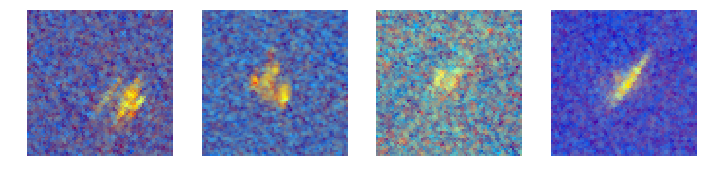

In [25]:
plots(iceberg_pics[194:198]) #Display four images from the dataset

# Cool - I can now view the json data files as images. Next, I'll process all the json data to images and save those images to their respective folders. 

In [26]:
import matplotlib

In [27]:
for i, x in enumerate(iceberg_pics):
    matplotlib.image.imsave(icebergPATH+'/iceberg%d.png' %i, x)

In [28]:
# same for the not icebergs
for i, x in enumerate(notberg_pics):
    matplotlib.image.imsave(notbergPATH+'/notberg%d.png' %i, x)

### Now we have to do all of the above for the test data. It has to be handled slightly differently, because we don't have a label column in this dataframe

In [29]:
test_df = pd.read_json('../../../iceberg/data/processed/test.json')

In [30]:
test_df.head()

,band_1,band_2,id,inc_angle
0,"[-15.863251, -15.201077, -17.887735, -19.17248...","[-21.629612, -21.142353, -23.908337, -28.34524...",5941774d,34.966400
1,"[-26.058969497680664, -26.058969497680664, -26...","[-25.754207611083984, -25.754207611083984, -25...",4023181e,32.615072
2,"[-14.14109992980957, -15.064241409301758, -17....","[-14.74563980102539, -14.590410232543945, -14....",b20200e4,37.505433
3,"[-12.167478, -13.706167, -16.54837, -13.572674...","[-24.32222, -26.375538, -24.096739, -23.8769, ...",e7f018bb,34.473900
4,"[-23.37459373474121, -26.02718162536621, -28.1...","[-25.72234344482422, -27.011577606201172, -23....",4371c8c3,43.918874


In [31]:
#convert arrays to rgb data arrays
test_pics = color_composite(test_df)

In [32]:
# save png files to the test folder
for i, x in zip(test_df['id'], test_pics):
    matplotlib.image.imsave(icebergTEST+'/im%s.png' %i, x)

In [33]:
# Memory cleanup now that we have completed preprocessing of the image json files. 

In [34]:
del train_df, test_df, iceberg_pics, notberg_pics, test_pics, icebergs, notbergs

In [35]:
import gc
gc.collect()

38680

## The kaggle kernel I have been following adds blur to the images, I wonder if I should bother with that step? I'm not really after the best model, I'm just trying to practice. I guess I could run through with the current images and then go back and try the blur "enhancement"

### On second thought, after reading about the filters that the example used (read the docs!), I think the benefits are worth the extra few lines of code. 

### (More) Image Processing (adding blur / sharpening)

In [36]:
print(icebergPATH)

../../../iceberg/data/train/iceberg


In [37]:
icebergs = os.listdir(icebergPATH)
notbergs = os.listdir(notbergPATH)
test = os.listdir(icebergTEST)

In [38]:
for x in icebergs:
    pp = Image.open('../../../iceberg/data/train/iceberg/'+x)
    pp = pp.filter(ImageFilter.MedianFilter(5))
    pp = pp.filter(ImageFilter.SHARPEN)
    pp.save('../../../iceberg/data/train/iceberg/'+x)
print('processed icebergs')

for x in notbergs:
    pp = Image.open('../../../iceberg/data/train/notberg/'+x)
    pp = pp.filter(ImageFilter.MedianFilter(5))
    pp = pp.filter(ImageFilter.SHARPEN)
    pp.save('../../../iceberg/data/train/notberg/'+x)
print('processed notbergs')

for x in test:
    pp = Image.open('../../../iceberg/data/test/'+x)
    pp = pp.filter(ImageFilter.MedianFilter(5))
    pp = pp.filter(ImageFilter.SHARPEN)
    pp.save('../../../iceberg/data/test/'+x)
print('processed test folder')

processed icebergs
processed notbergs
processed test folder


In [39]:
# Now I need to pull some of the iceberg and notberg pictures and place them in the validation folder
# i.e. I need to create a validation set for my model

allnots = os.listdir(notbergPATH+'/')
iceberg = os.listdir(icebergPATH+'/')

#Check how many files exist in each folder
print(len(allnots), len(iceberg))

851 753


In [40]:
sample_iceberg = np.random.choice(iceberg, size=150)
sample_iceberg = list(set(sample_iceberg))

sample_allnots = np.random.choice(allnots, size=150)
sample_allnots = list(set(sample_allnots))

In [41]:
for x in sample_iceberg:
    shutil.move('../../../iceberg/data/train/iceberg/'+x, '../../../iceberg/data/valid/iceberg/'+x)

for x in sample_allnots:
    shutil.move('../../../iceberg/data/train/notberg/'+x, '../../../iceberg/data/valid/notberg/'+x)

In [42]:
#Check to make sure the files moved to the appropriate folders
allnots = os.listdir(notbergPATH+'/')
iceberg = os.listdir(icebergPATH+'/')
print(len(allnots), len(iceberg))

713 620


In [43]:
len(os.listdir(icebergTEST))

8424

# Right now, I have now organized the data into folders that exactly matches the lesson 1 example from the fast.ai deep learning course. So, at this stage, let's just run the basic training example, and see what kind of results I come up with. 

In [44]:
sz = 75
bs = 64
arch=resnet50   #Changing to ResNet50 on June 13th, to see if the results are any better (~76% validation accuracy)

# Let's update based on lesson 3 lecture showing the "quick" path to obtaining results. 
# I'm going to add augmentation to bolster the training data. 

tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs, test_name='test')
learn = ConvLearner.pretrained(arch, data)
%time learn.fit(0.01, 3, cycle_len=1) #precompute=True is just a time saver, when in doubt leave it out
                                        # Also, it will render augmentation useless, because it uses cached data

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/charlierock/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:16<00:00, 6396815.96it/s]


epoch      trn_loss   val_loss   accuracy                  
    0      0.693947   0.487406   0.729508  
    1      0.565109   0.410659   0.79918                   
    2      0.514072   0.413261   0.784836                  

CPU times: user 7.5 s, sys: 1.32 s, total: 8.82 s
Wall time: 6.23 s


[array([0.41326]), 0.7848360675280212]

### that was insanely fast (I guess the train folders don't have a ton of images, and they are small images. ResNet50 yields better accuracy, but our training and validation loss numbers aren't great. 

In [45]:
lrf = learn.lr_find()

epoch      trn_loss   val_loss   accuracy                  
    0      1.102723   151.673479 0.586066  



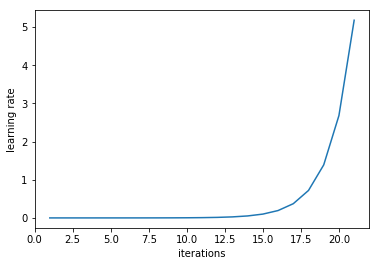

In [46]:
learn.sched.plot_lr()

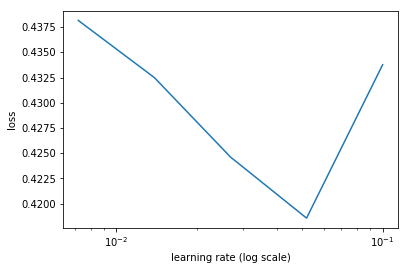

In [47]:
learn.sched.plot()

### The above charts are rather segmented. I'm going to have to do some digging to figure out why they aren't as smooth as the in-class example. I wonder if the smaller dataset has something to do with it. Perhaps these functions take only a small sample of the training data?

In [48]:
lr = 0.01 #Still seems to be the best choice for this model. Gonna try a few more epochs to see what happens

In [49]:
%time learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                  
    0      0.449753   0.403971   0.797131  
    1      0.439038   0.39895    0.795082                  
    2      0.439924   0.372717   0.819672                  
    3      0.436187   0.37853    0.79918                   
    4      0.428717   0.379102   0.82377                   
    5      0.417815   0.371673   0.82377                   
    6      0.406089   0.370977   0.831967                  

CPU times: user 16 s, sys: 2.45 s, total: 18.4 s
Wall time: 11.9 s


[array([0.37098]), 0.8319672150690047]

### With ResNet50, the loss is getting better, but not by much. Accuracy is up to 83.2%, with just a change to the model architecture (ResNet50 vs. ResNet34). Not sure what is going on here, time to dive into the forums. Going to try a another trick (unfreeze all the layers and retrain, then see where I'm at. 

1. precompute=True
1. Use `lr_find()` to find highest learning rate where loss is still clearly improving (done)
1. Train last layer from precomputed activations for 1-2 epochs (done)
1. Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1 (done)
1. Unfreeze all layers <--- This is where to go next
1. Set earlier layers to 3x-10x lower learning rate than next higher layer
1. Use `lr_find()` again
1. Train full network with cycle_mult=2 until over-fitting

In [50]:
learn.unfreeze()
lrs = np.array([lr/9, lr/3, lr]) #Differential learning rates for satellite projects
%time learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                  
    0      0.577785   0.419117   0.79918   
    1      0.465763   0.352583   0.831967                  
    2      0.408962   0.324849   0.829918                  

CPU times: user 13 s, sys: 1.88 s, total: 14.8 s
Wall time: 12.1 s


[array([0.32485]), 0.8299180327868853]

### Well, the loss started going down, and the accuracy started improving. I'm going to run a few more epochs to see if I can keep that going. 

In [51]:
%time learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                  
    0      0.330803   0.314454   0.858607  
    1      0.334309   0.307776   0.844262                  
    2      0.313088   0.298756   0.866803                  
    3      0.295277   0.296324   0.860656                  
    4      0.2865     0.249774   0.883197                  
    5      0.272909   0.240306   0.891393                  
    6      0.259037   0.236099   0.903689                  

CPU times: user 30.5 s, sys: 4.36 s, total: 34.9 s
Wall time: 28.6 s


[array([0.2361]), 0.9036885245901639]

### Whoa! That brought me up to 90% accuracy, this is way better than my previous results. That's cool

In [52]:
# This seems to be a pretty decent model now. What's next? Try lr_find? 
lrf = learn.lr_find()

 90%|█████████ | 19/21 [00:03<00:00,  5.68it/s, loss=2.38] 


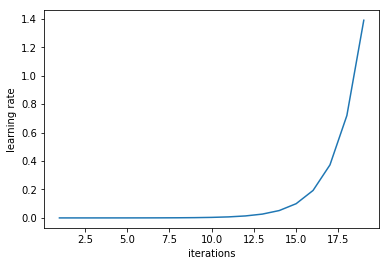

In [53]:
learn.sched.plot_lr()

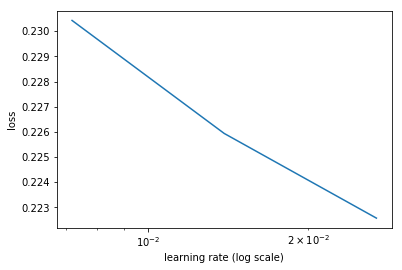

In [54]:
learn.sched.plot()

### Weird, I should try to hit the forums to find out what the above plot means for the model and learning rate? 

In [55]:
# Gonna re-run the model one more time, just for grins
%time learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                  
    0      0.235164   0.230439   0.909836  
    1      0.241295   0.249128   0.895492                  
    2      0.238498   0.223791   0.903689                  
    3      0.245924   0.229219   0.903689                  
    4      0.231508   0.22083    0.89959                   
    5      0.213649   0.224578   0.901639                  
    6      0.199496   0.227004   0.909836                  

CPU times: user 30.1 s, sys: 3.97 s, total: 34.1 s
Wall time: 27.6 s


[array([0.227]), 0.9098360655737705]

## Definitely have plateaued here. Time to give predictions a shot and see where that places me. Next, time to understand what I need, and what kind of model I want to build for the Flint project. The next steps may involve more note-taking and reading, than coding. I'm starting to get a grasp of the workflow though, so I'm pleased with that. I can complete lectures and the course as time permits. #lifewithbaby

In [56]:
#Lets look at the data a little before creating a submission to the (long completed) competition
data.classes

['iceberg', 'notberg']

In [57]:
%time log_preds, y = learn.TTA(is_test=True) #Set is_test to True because we have a full test set. 

CPU times: user 49.5 s, sys: 8.62 s, total: 58.1 s
Wall time: 32.9 s


In [58]:
# We have to average the first dimension of the predictions because using TTA, we get a separate prediction for each augmented image + the original
ice_preds = np.mean(np.exp(log_preds), axis=0)

In [59]:
ice_preds.shape

(8424, 2)

In [60]:
ice_preds[0]

array([0.99873, 0.00127], dtype=float32)

In [61]:
#Creating the submission file
df = pd.DataFrame(ice_preds)

In [62]:
df.columns = data.classes

In [63]:
#Get id names to insert
data.test_ds.fnames[:10]

['test/imbf310e17.png',
 'test/im636199c1.png',
 'test/imb10142f6.png',
 'test/im61ba89c0.png',
 'test/im8c5d18fd.png',
 'test/im40be9d39.png',
 'test/ime1f9dbd9.png',
 'test/imf883065d.png',
 'test/im1f919bdb.png',
 'test/im9b21f1d0.png']

In [64]:
df.insert(0,'id',[y.split('/')[-1].split('.')[0][2:] for y in data.test_ds.fnames ])

In [65]:
df.head()

,id,iceberg,notberg
0,bf310e17,0.998733,0.001267
1,636199c1,0.054695,0.945305
2,b10142f6,0.296521,0.703479
3,61ba89c0,0.000817,0.999183
4,8c5d18fd,0.001375,0.998625


In [66]:
submission = df[['id', 'iceberg']]
submission.columns = ['id', 'is_iceberg']
submission.to_csv(PATH+'iceberg_sub2_RN50.csv', index=False)

In [67]:
submission.head()

,id,is_iceberg
0,bf310e17,0.998733
1,636199c1,0.054695
2,b10142f6,0.296521
3,61ba89c0,0.000817
4,8c5d18fd,0.001375


# Well, I did it. I created a submission. It's not the greatest, but I knew that going in. I did it for practice, and learning, and that's what I got out of it. I can keep digging to understand what's going on under the hood. It'll be good to have this under my belt as I go through the class, and also go through with the Flint Project. 